# Elliptic Function LPF {#sec-elliptic-function}

![Elliptic Function LPF](Elliptic-function-VCVS-LPF.png){#fig-elliptic-function-LPF}

## Introduction
The circuit shown above is an elliptic function low pass filter. The design of elliptic filters is somewhat complex and usually involves the use of tables found in filter design handbooks. The symbolic solution of the network equations takes about 2 hours on a i3 machine. Initially I was thinking that a symbolic solution of the equations and the use of SciPy's filter functions, I could derive the element values for active elliptic filters. But since the subject of this book is MNA and not filter design, only the analysis of the filter is described.  

## Circuit description
The circuit in @fig-elliptic-function-LPF has 13 branches and 7 nodes. There are 12 passive components and one OpAmp. The circuit is from @Williams1995, example 3-26, and is an elliptic function low pass filter with a cutoff frequency of 100 Hz. The schematic for the filter was entered into LTSpice and an the following netlist was obtained.

```
R3 3 0 4750
R4 5 0 73.2k
R1 4 1 9530
R2 5 4 9530
R7 2 7 10k
C1 3 1 0.05µ
C2 5 3 0.05µ
C3 7 4 0.1µ
C4 5 0 0.22µ
C5 2 0 0.18µ
XU1 6 5 7 opamp Aol=100K GBW=10Meg
V1 1 0 AC 1
R6 7 6 44.2k
R5 6 0 10k
```

The following Python modules are used in this notebook.

In [1]:
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

### Network equations
The netlist generated by LTSpice is pasted into the cell below and some edits were made to fix up the formating of the component values and the OpAmp declaration.

In [2]:
example_net_list = '''
R3 3 0 4750
R4 5 0 73.2e3
R1 4 1 9530
R2 5 4 9530
R7 2 7 10e3
C1 3 1 0.05e-6
C2 5 3 0.05e-6
C3 7 4 0.1e-6
C4 5 0 0.22e-6
C5 2 0 0.18e-6
O1 6 5 7 
V1 1 0 1
R6 7 6 44.2e3
R5 6 0 10e3
'''

Callin smna() to generate the network equations.

In [3]:
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

equ = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [4]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$- C_{1} s v_{3} + I_{V1} + v_{1} \left(C_{1} s + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{1}} = 0$<br>$v_{2} \left(C_{5} s + \frac{1}{R_{7}}\right) - \frac{v_{7}}{R_{7}} = 0$<br>$- C_{1} s v_{1} - C_{2} s v_{5} + v_{3} \left(C_{1} s + C_{2} s + \frac{1}{R_{3}}\right) = 0$<br>$- C_{3} s v_{7} + v_{4} \left(C_{3} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{5}}{R_{2}} - \frac{v_{1}}{R_{1}} = 0$<br>$- C_{2} s v_{3} + v_{5} \left(C_{2} s + C_{4} s + \frac{1}{R_{4}} + \frac{1}{R_{2}}\right) - \frac{v_{4}}{R_{2}} = 0$<br>$v_{6} \cdot \left(\frac{1}{R_{6}} + \frac{1}{R_{5}}\right) - \frac{v_{7}}{R_{6}} = 0$<br>$- C_{3} s v_{4} + I_{O1} + v_{7} \left(C_{3} s + \frac{1}{R_{7}} + \frac{1}{R_{6}}\right) - \frac{v_{2}}{R_{7}} - \frac{v_{6}}{R_{6}} = 0$<br>$v_{1} = V_{1}$<br>$- v_{5} + v_{6} = 0$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand and a symbolic soultion would take a lot of computing time. The equations are displace in matrix notation.

In [5]:
equ

⎡                          ⎛       1 ⎞   v₄     ⎤       
⎢     -C₁⋅s⋅v₃ + I_V1 + v₁⋅⎜C₁⋅s + ──⎟ - ──     ⎥       
⎢                          ⎝       R₁⎠   R₁     ⎥       
⎢                                               ⎥       
⎢                 ⎛       1 ⎞   v₇              ⎥       
⎢              v₂⋅⎜C₅⋅s + ──⎟ - ──              ⎥       
⎢                 ⎝       R₇⎠   R₇              ⎥       
⎢                                               ⎥   ⎡0 ⎤
⎢                          ⎛              1 ⎞   ⎥   ⎢  ⎥
⎢  -C₁⋅s⋅v₁ - C₂⋅s⋅v₅ + v₃⋅⎜C₁⋅s + C₂⋅s + ──⎟   ⎥   ⎢0 ⎥
⎢                          ⎝              R₃⎠   ⎥   ⎢  ⎥
⎢                                               ⎥   ⎢0 ⎥
⎢                 ⎛       1    1 ⎞   v₅   v₁    ⎥   ⎢  ⎥
⎢   -C₃⋅s⋅v₇ + v₄⋅⎜C₃⋅s + ── + ──⎟ - ── - ──    ⎥   ⎢0 ⎥
⎢                 ⎝       R₂   R₁⎠   R₂   R₁    ⎥   ⎢  ⎥
⎢                                               ⎥ = ⎢0 ⎥
⎢                ⎛              1    1 ⎞   v₄   ⎥   ⎢  ⎥
⎢  -C₂⋅s⋅v₃ + v₅⋅⎜C₂⋅s + C₄⋅s +

Turn the free symbols into SymPy variables.

In [6]:
var(str(equ.free_symbols).replace('{','').replace('}',''))

Built a dictionary of element values.

In [7]:
element_values = SymMNA.get_part_values(network_df)
element_values

{C₁: 5e-08, C₂: 5e-08, C₃: 1e-07, C₄: 2.2e-07, C₅: 1.8e-07, O₁: nan, R₁: 9530.
0, R₂: 9530.0, R₃: 4750.0, R₄: 73200.0, R₅: 10000.0, R₆: 44200.0, R₇: 10000.0,
 V₁: 1.0}

## Symbolic solution
The symbolic solution takes a long time, 2 hours, on my laptop (i3-8130U CPU @ 2.20GHz), so I commended the code. Going to write some code to save off the results to a pickle file.

In [8]:
#U_sym = solve(equ,X)

## Numerical solution
Substitue the element values into the equations and solve for unknown node voltages and currents. Need to set the current source, I1, to zero.

In [9]:
equ_N = equ.subs(element_values)
equ_N

⎡          I_V1 - 5.0e-8⋅s⋅v₃ + v₁⋅(5.0e-8⋅s + 0.000104931794333683) - 0.00010
⎢                                                                             
⎢                                  v₂⋅(1.8e-7⋅s + 0.0001) - 0.0001⋅v₇         
⎢                                                                             
⎢                   -5.0e-8⋅s⋅v₁ - 5.0e-8⋅s⋅v₅ + v₃⋅(1.0e-7⋅s + 0.000210526315
⎢                                                                             
⎢-1.0e-7⋅s⋅v₇ - 0.000104931794333683⋅v₁ + v₄⋅(1.0e-7⋅s + 0.000209863588667366)
⎢                                                                             
⎢             -5.0e-8⋅s⋅v₃ - 0.000104931794333683⋅v₄ + v₅⋅(2.7e-7⋅s + 0.000118
⎢                                                                             
⎢                            0.00012262443438914⋅v₆ - 2.26244343891403e-5⋅v₇  
⎢                                                                             
⎢     I_O1 - 1.0e-7⋅s⋅v₄ - 0.0001⋅v₂ - 2.26244343891

Solve for voltages and currents in terms of Laplace variable s.

In [10]:
U = solve(equ_N,X)

### Find the network transfer function $\frac {v_2(s)}{v_1(s)}$

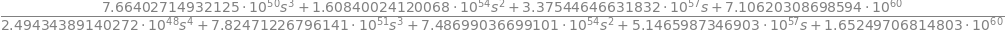

In [11]:
H = (U[v2]/U[v1]).cancel()
H

In [12]:
H_num, H_denom = fraction(H) #returns numerator and denominator

In [13]:
# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)
sys = signal.TransferFunction(a,b)

### Poles and zeros of the low pass transfer function
The poles and zeros of the transfer function can easly be obtained with the following code:

In [14]:
sys_zeros = np.roots(sys.num)
sys_poles = np.roots(sys.den)

#### Low pass filter pole zero plot
The poles and zeros of the preamp transfer function are plotted.

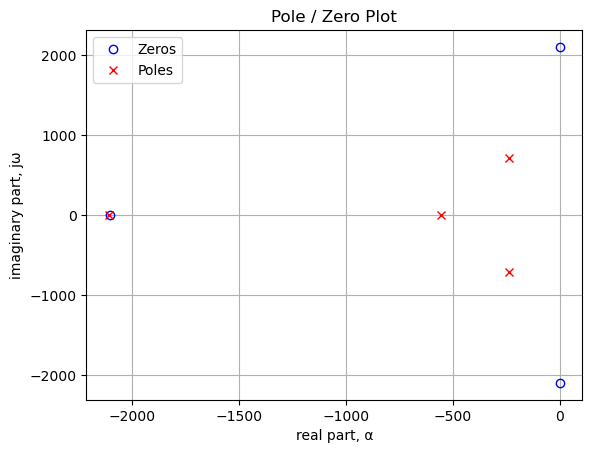

In [15]:
plt.plot(np.real(sys_zeros), np.imag(sys_zeros), 'ob', markerfacecolor='none')
plt.plot(np.real(sys_poles), np.imag(sys_poles), 'xr')
plt.legend(['Zeros', 'Poles'], loc=0)
plt.title('Pole / Zero Plot')
plt.xlabel('real part, \u03B1')
plt.ylabel('imaginary part, j\u03C9')
plt.grid()
plt.show()

Poles and zeros of the transfer function plotted on the complex plane. The units are in radian frequency.

Printing these values in Hz.

In [16]:
print('number of zeros: {:d}'.format(len(sys_zeros)))
for i in sys_zeros:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of zeros: 3
-334.53+0.00j Hz
0.26+334.27j Hz
0.26-334.27j Hz


In [17]:
print('number of poles: {:d}'.format(len(sys_poles)))
for i in sys_poles:
    print('{:,.2f} Hz'.format(i/(2*np.pi)))

number of poles: 4
-335.18+0.00j Hz
-37.83+113.63j Hz
-37.83-113.63j Hz
-88.42+0.00j Hz


## AC analysis
Solve the network equations at a frequency of 100 Hz or $\omega$ equal to 628.318 radians per second, s = 628.318j.

Load numerical values into the network equations.

In [18]:
freq_Hz = 100 #Hz
w = 2*np.pi*freq_Hz

equ_Nw = equ.subs(element_values)
equ_Nw = equ_Nw.subs({s:1j*w})
equ_Nw  # display the equations

⎡          I_V1 + v₁⋅(0.000104931794333683 + 3.14159265358979e-5⋅ⅈ) - 3.141592
⎢                                                                             
⎢                                        v₂⋅(0.0001 + 0.000113097335529233⋅ⅈ) 
⎢                                                                             
⎢            -3.14159265358979e-5⋅ⅈ⋅v₁ + v₃⋅(0.000210526315789474 + 6.28318530
⎢                                                                             
⎢-0.000104931794333683⋅v₁ + v₄⋅(0.000209863588667366 + 6.28318530717959e-5⋅ⅈ) 
⎢                                                                             
⎢            -3.14159265358979e-5⋅ⅈ⋅v₃ - 0.000104931794333683⋅v₄ + v₅⋅(0.00011
⎢                                                                             
⎢                                         0.00012262443438914⋅v₆ - 2.262443438
⎢                                                                             
⎢     I_O1 - 0.0001⋅v₂ - 6.28318530717959e-5⋅ⅈ⋅v₄ - 

Solve the newtork equations and list the node voltages and unknown currents.

In [19]:
U_Nw = solve(equ_Nw,X)

table_header = ['unknown', 'mag','phase, deg']
table_row = []

for name, value in U_Nw .items():
    table_row.append([str(name),float(abs(value)),float(arg(value)*180/np.pi)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal','decimal'),tablefmt="simple",floatfmt=('5s','.6f','.6f')))

unknown         mag    phase, deg
---------  --------  ------------
v1         1.000000      0.000000
v2         4.264586   -108.662048
v3         0.271069     40.463593
v4         2.401757     -6.456457
v5         1.187844    -60.144973
v6         1.187844    -60.144973
v7         6.438113    -60.144973
I_V1       0.000150    -20.838911
I_O1       0.000875    166.380500


## AC Sweep
Plot the magnitude and phase of the filter's transfer function.

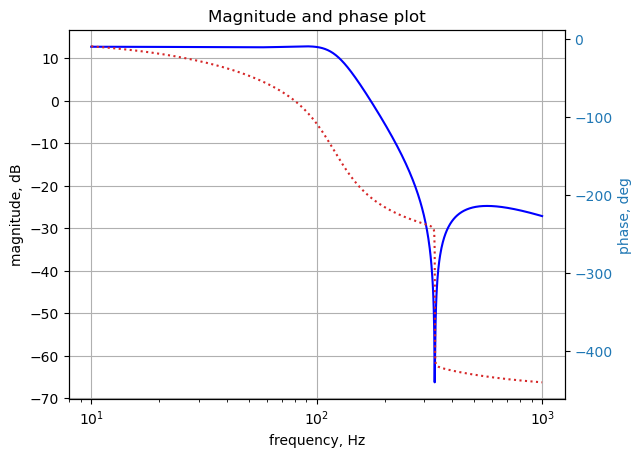

In [20]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b) # system for circuit 1

x = np.logspace(1, 3, 1000, endpoint=True)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # magnitude plot

ax1.tick_params(axis='y')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase plot')
plt.show()

## Summary
An elliptic filter was analyized and a symbolic solution of the network equations takes a long time. Numerical solutions using component values are easily obtained.